# Imports

In [1]:
# %matplotlib qt5

%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mathphys.functions import load, save
import mathphys.constants as cons
from pycolleff.longitudinal_equilibrium import ImpedanceSource, LongitudinalEquilibrium

from pycolleff.rings import maxiv, als, half, sirius

from pycolleff.longitudinal_equilibrium import _mytrapz

from pycolleff.colleff import Ring

import matplotlib as mplt
import matplotlib.cm as cmap

import scienceplots
from itertools import product

mplt.style.use('science')

plt.rcParams.update({
    'font.size': 18, 'axes.grid': True,
    'grid.linestyle': '--', 'grid.alpha': 0.5})

plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.right'] = False
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['xtick.top'] = False

c = 299_792_458

# Methods

In [27]:
def calc_equilibrium_for_fixed_detuning(
    ring, hcav, current, detune, longeq=None
):
    """Calculate the equilibrium for a fixed cavity and current."""
    h = ring.harm_num    
    ring.total_current = current
    fill = np.ones(h)/h
    
    if longeq is None:
        longeq = LongitudinalEquilibrium(
            ring=ring, impedance_sources=[hcav, ],
            fillpattern=fill)
        longeq.feedback_on = False
        longeq.zgrid = np.linspace(-1, 1, 2001) * ring.rf_lamb/2
        # longeq.zgrid = np.linspace(-0.9, 0.9, 2001) * ring.rf_lamb/2
    else:
        longeq.ring = ring
        longeq.impedance_sources = [hcav]
        longeq.ring.total_current = current
        longeq.fillpattern = fill
    longeq.identical_bunches = True
    longeq.impedance_sources[0].detune_w = 2*np.pi*detune
    _ = longeq.calc_longitudinal_equilibrium(
            niter=1_000, tol=1e-8, beta=0.1, print_flag=False, m=3)
    return longeq


def calc_equilibrium_for_flat_potential(
    ring, hcav, current, nr_iters=7, longeq=None
):
    """Calculate equilibrium to flat potential condition.

    This method will change the detune_angle of the cavity so that
    the beam induced voltage amplitude matches the flat potential
    condition.

    It will iterate a few times so that the form factor of the
    distribution converges.
    """
    h = ring.harm_num    
    fill = np.ones(h)/h
    ring.total_current = current
    
    if longeq is None:
        longeq = LongitudinalEquilibrium(
            ring=ring, impedance_sources=[hcav, ],
            fillpattern=fill)
        longeq.feedback_on = False
        longeq.zgrid = np.linspace(-1, 1, 2001) * ring.rf_lamb/2
        # longeq.zgrid = np.linspace(-0.9, 0.9, 2001) * ring.rf_lamb/2
    else:
        longeq.ring = ring
        longeq.impedance_sources = [hcav]
        longeq.ring.total_current = current
        longeq.fillpattern = fill
    longeq.identical_bunches = True
    
    for _ in range(nr_iters):
        kharm = longeq.calc_harmonic_voltage_for_flat_potential()
        vharm = kharm * longeq.ring.gap_voltage
        angle = longeq.calc_detune_for_fixed_harmonic_voltage(
            vharm, Rs=hcav.shunt_impedance)
        hcav.detune_angle = angle
        longeq.impedance_sources[0] = hcav
#         print(f'detune: {hcav.detune_w/2/np.pi/1e3:.3f} kHz')

        _ = longeq.calc_longitudinal_equilibrium(
                niter=1000, tol=1e-8, beta=0.1, print_flag=False, m=3)
    return longeq


################################################################################
def calc_lmci(
    longeq,
    cbmode=1,
    max_azi=2,
    max_rad=1,
    fokker=True,
    delete_m0=True,
    delete_m0k0=True,
    sync_method='sigma',
):
    """Calculate LMCI for a given coupled bunch mode and equilibrium condition.

    Args:
        longeq: object from Longitudinal equilibrium class;
        cbmode: coupled-bunch mode to evaluate must be in range [0, h-1].
            Defaults to 1, which is the mode of PTBL instability;
        max_azi: maximum azimuthal mode to consider in expansion.
            Detaults to 2. Found to be enough to explain PTBL instability;
        max_azi: maximum radial mode to consider in expansion. Defaults to 1.
            Also found to be enough to explain PTBL instability.

    Returns:
        eigenfreq: complex coherent eigen angular frequencies in [rad/s];
        freqshift: frequency of the most unstable mode in [Hz];
        grate: growth rate of the most unstable mode in [1/s];
        sync_freq: incoherent synchrotron frequency used in calculations [Hz];
        peak_hvolt: peak voltage of harmonic cavity [V].
    
    """   
    hcav = longeq.impedance_sources[0]
    hvolt = longeq.calc_induced_voltage_wake(
        dist=longeq.distributions, wake_source=hcav)
    mvolt = longeq.main_voltage
    tvolt = mvolt + hvolt
    peak_hvolt = np.max(np.abs(hvolt[0, :]))
    peak_mvolt = np.max(np.abs(mvolt))

    print(f'current: {longeq.ring.total_current*1e3:.2f} mA')
    print(f'detune: {hcav.detune_w/2/np.pi/1e3:.3f} kHz')
    print(f'detune angle: {np.rad2deg(hcav.detune_angle):.1f} deg')
    print(f'R/Q: {hcav.shunt_impedance/hcav.Q:.1f} Ohm')
    print(f'HC voltage: {peak_hvolt/1e3:.1f} kV')
    ratio = peak_hvolt/peak_mvolt
    print(f'HC voltage ratio: {ratio:.3f}')

    wrf = longeq.ring.rf_ang_freq
    dist, pot = longeq.calc_distributions_from_voltage(tvolt)
    z0, sigmaz = longeq.calc_moments(longeq.zgrid, dist[0])
    sigmaz = sigmaz[0]
    longeq.ring.bunlen = sigmaz

    # Calculate the equivalent synchrotron frequency:
    if sync_method.startswith('sigma'):
        # use fórmula based on bunch length:
        sync_freq = longeq.ring.espread * longeq.ring.mom_comp * c
        sync_freq /= sigmaz * 2 * np.pi
    elif sync_method.startswith('average'):
        # use average of distribution:
        longeq.calc_equilibrium_info(
            tvolt, method="action", max_amp=5, nrpts=100)
        sync_freq = longeq.equilibrium_info['avg_sync_freq']
    elif sync_method.startswith('derivative'):
        # use average of square root of gap voltage:
        longeq.calc_equilibrium_info(
            tvolt, method="derivative", max_amp=5, nrpts=100)
        sync_freq = longeq.equilibrium_info['avg_sync_freq']
    longeq.ring.sync_tune = sync_freq / longeq.ring.rev_freq
    
    print(f"sync. freq.: {longeq.ring.sync_tune * longeq.ring.rev_freq:.3f} Hz")
    print(f'bunch length: {longeq.ring.bunlen*1e3:.3f} mm')

    # Calculate Vlasov's equation eigen-frequencies:
    wrf = longeq.ring.rf_ang_freq
    reduced = False
    eigenfreq, *_ = longeq.calc_mode_coupling(
        w=[-10*wrf, +10*wrf], 
        cbmode=cbmode,
        max_azi=max_azi,
        max_rad=max_rad, 
        use_fokker=fokker,
        reduced=reduced,
        delete_m0=delete_m0,
        delete_m0k0=delete_m0k0,
    )

    # Find most unstable mode:
    idx = np.argmax(eigenfreq.imag)
    freqshift = eigenfreq.real[idx] / 2 / np.pi
    grate = eigenfreq.imag[idx]
    if reduced:
        # Subtract radiation damping rate from "reduced" simulation:
        grate -= 1/longeq.ring.dampte

    print('Most unstable mode:')
    print(f'    frequency: {freqshift:.2f} Hz')
    print(f'    growth rate: {grate:.2f} 1/s')
    print('\n')
    return eigenfreq, freqshift, grate, sync_freq, peak_hvolt


def calc_lmci_scan_current(ring, hcav, current_scan):
    """Calculate equilibrium and solve Vlasov equation for a current set.

    The cavity will be detuned to flat potential condition at each current.
    
    """
    growths, shifts, syncdata, peak_hvolts = [], [], [], []
    longeq = None
    cbmode = 1
    # cbpmode = ring.harm_num-1
    for i, current in enumerate(current_scan):
        longeq = calc_equilibrium_for_flat_potential(
            ring, hcav, current=current, nr_iters=8, longeq=longeq,
        )
        eigenfreq, tuneshift, grate, sync_freq, peak_hvolt = calc_lmci(
            longeq, cbmode=cbmode, max_azi=3, max_rad=2,
        )
        growths.append(grate)
        shifts.append(tuneshift)
        syncdata.append(sync_freq)
        peak_hvolts.append(peak_hvolt)
    growths = np.array(growths)
    shifts = np.array(shifts)
    syncdata = np.array(syncdata)
    peak_hvolts = np.array(peak_hvolts)
    return growths, shifts, syncdata, peak_hvolts


def calc_lmci_scan_detuning(
    ring,
    hcav,
    current,
    detuning_scan,
    fokker=True,
    delete_m0=True,
    delete_m0k0=True,
    sync_method='sigma',
):
    """Calculate equilibrium and solve Vlasov equation for a detuning set."""
    growths, shifts, syncdata, peak_hvolts = [], [], [], []
    longeq = None
    cbmode = 1
    # cbpmode = ring.harm_num-1
    for i, detune in enumerate(detuning_scan):
        longeq = calc_equilibrium_for_fixed_detuning(
            ring, hcav, current, detune=detune, longeq=longeq,
        )
        eigenfreq, tuneshift, grate, sync_freq, peak_hvolt = calc_lmci(
            longeq,
            cbmode=cbmode,
            max_azi=3,
            max_rad=2,
            fokker=fokker,
            delete_m0=delete_m0,
            delete_m0k0=delete_m0k0,
            sync_method=sync_method,
        )
        growths.append(grate)
        shifts.append(tuneshift)
        syncdata.append(sync_freq)
        peak_hvolts.append(peak_hvolt)
    growths = np.array(growths)
    shifts = np.array(shifts)
    syncdata = np.array(syncdata)
    peak_hvolts = np.array(peak_hvolts)
    return growths, shifts, syncdata, peak_hvolts

# MAX-IV

In [28]:
ring = maxiv.create_ring(energy=3)
ring.gap_voltage = 1.397e6
ring.total_current = 300e-3

print(ring)

Lattice Version             :     MAX-IV-3GeV     
Circumference [m]           :       527.999       
Revolution Period [us]      :        1.761        
Revolution Frequency [kHz]  :       567.790       
Energy [GeV]                :        3.000        
U0 [keV]                    :       363.800       
Vgap [MV]                   :        1.397        
Momentum Compaction         :       3.06e-04      
Harmonic Number             :         176         
Current [mA]                :       300.000       
Current per Bunch [mA]      :        1.705        
Synchrotron Tune            :       0.00164       
Tunes x/y                   :    16.280/42.200    
Chromaticities x/y          :     1.000/1.000     
Damping Times x/y/e [ms]    :   15.7/ 29.0 /25.2  
Energy Spread [%]           :        0.0769       
Bunch Length [mm]           :        10.694       



In [29]:
hcav = ImpedanceSource()
hcav.harm_rf = 3
hcav.Q = 20_800
ncavs = 3
hcav.shunt_impedance = 2.75e6 * ncavs 

twopi = 2*np.pi
hcav.ang_freq_rf = twopi*ring.rf_freq
hcav.ang_freq = hcav.harm_rf*hcav.ang_freq_rf

hcav.detune_w = twopi*25e3
hcav.calc_method = ImpedanceSource.Methods.ImpedanceDFT
hcav.active_passive = ImpedanceSource.ActivePassive.Passive

In [30]:
current_scan = np.linspace(250, 400, 30)*1e-3
grate, freq, sync_freq, peak_hvolt = calc_lmci_scan_current(ring, hcav, current_scan)

current: 250.00 mA
detune: 62.531 kHz
detune angle: 83.4 deg
R/Q: 396.6 Ohm
HC voltage: 447.6 kV
HC voltage ratio: 0.320
sync. freq.: 215.450 Hz
bunch length: 52.113 mm
Most unstable mode:
    frequency: 132.82 Hz
    growth rate: -27.44 1/s


current: 255.17 mA
detune: 63.831 kHz
detune angle: 83.6 deg
R/Q: 396.6 Ohm
HC voltage: 447.7 kV
HC voltage ratio: 0.320
sync. freq.: 215.339 Hz
bunch length: 52.139 mm
Most unstable mode:
    frequency: 128.40 Hz
    growth rate: -26.40 1/s


current: 260.34 mA
detune: 65.144 kHz
detune angle: 83.7 deg
R/Q: 396.6 Ohm
HC voltage: 447.7 kV
HC voltage ratio: 0.320
sync. freq.: 215.419 Hz
bunch length: 52.120 mm
Most unstable mode:
    frequency: 124.19 Hz
    growth rate: -25.29 1/s


current: 265.52 mA
detune: 66.457 kHz
detune angle: 83.8 deg
R/Q: 396.6 Ohm
HC voltage: 447.7 kV
HC voltage ratio: 0.320
sync. freq.: 215.505 Hz
bunch length: 52.099 mm
Most unstable mode:
    frequency: 119.77 Hz
    growth rate: -24.07 1/s


current: 270.69 mA
detun

<IPython.core.display.Javascript object>


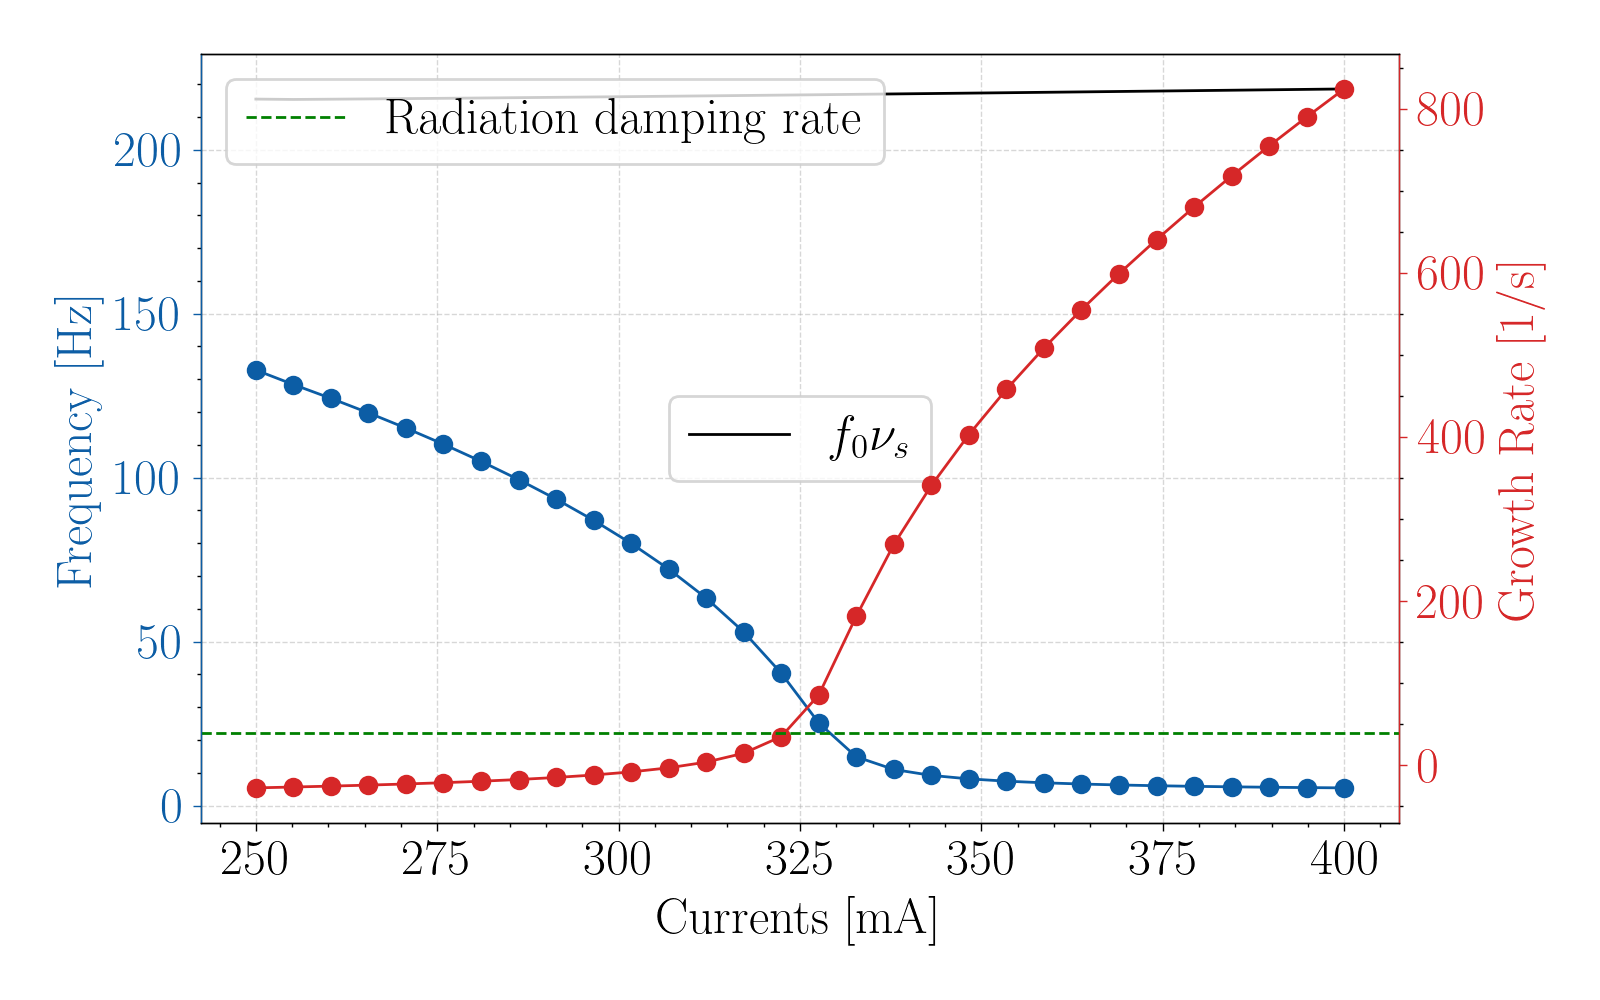

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ay = ax.twinx()

ax.plot(current_scan*1e3, freq, 'o-')
ax.plot(current_scan*1e3, sync_freq, color='k', label=r'$f_0\nu_s$')
ay.plot(current_scan*1e3, np.array(grate), 'o-', color='tab:red')

ay.grid(False)
ay.spines['right'].set_color('tab:red')
# plt.setp(ay.yaxis.get_ticklabels(), color='tab:red')
ay.tick_params(axis='y', colors='tab:red')

ay.spines['left'].set_color('C0')
plt.setp(ax.yaxis.get_ticklabels(), color='tab:red')
ax.tick_params(axis='y', colors='C0')

ax.legend(loc='center', frameon=True)
ax.set_ylabel('Frequency [Hz]', color='C0')
ax.set_xlabel('Currents [mA]')
ay.set_ylabel('Growth Rate [1/s]', color='tab:red')
ay.axhline(1/ring.dampte, color='g', label='Radiation damping rate', ls='--')
ay.legend(frameon=True)
fig.tight_layout()
fig.show()

In [32]:
current = 300e-3
detune_scan = np.linspace(77.5, 73, 20)*1e3
# detune_scan = detune_scan[:14]
fokker = True
delete_m0 = True
delete_m0k0 = True
sync_method = 'average'
grate, freq, sync_freq, peak_hvolt = calc_lmci_scan_detuning(
    ring,
    hcav,
    current,
    detune_scan,
    fokker=fokker,
    delete_m0=delete_m0,
    delete_m0k0=delete_m0k0,
    sync_method=sync_method,
)

current: 300.00 mA
detune: 77.500 kHz
detune angle: 84.7 deg
R/Q: 396.6 Ohm
HC voltage: 440.1 kV
HC voltage ratio: 0.315
sync. freq.: 218.285 Hz
bunch length: 45.509 mm
Most unstable mode:
    frequency: 95.76 Hz
    growth rate: -14.43 1/s


current: 300.00 mA
detune: 77.263 kHz
detune angle: 84.7 deg
R/Q: 396.6 Ohm
HC voltage: 440.9 kV
HC voltage ratio: 0.316


/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1066: RuntimeWarning: invalid value encountered in sqrt
  return _np.sqrt((2 / alpha) * (h0i - phi))
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pyc

sync. freq.: 214.011 Hz
bunch length: 46.134 mm
Most unstable mode:
    frequency: 82.71 Hz
    growth rate: -9.90 1/s


current: 300.00 mA
detune: 77.026 kHz
detune angle: 84.7 deg
R/Q: 396.6 Ohm
HC voltage: 441.7 kV
HC voltage ratio: 0.316


/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1066: RuntimeWarning: invalid value encountered in sqrt
  return _np.sqrt((2 / alpha) * (h0i - phi))
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pyc

sync. freq.: 209.751 Hz
bunch length: 46.768 mm
Most unstable mode:
    frequency: 67.32 Hz
    growth rate: -2.24 1/s


current: 300.00 mA
detune: 76.789 kHz
detune angle: 84.6 deg
R/Q: 396.6 Ohm
HC voltage: 442.5 kV
HC voltage ratio: 0.317


/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1066: RuntimeWarning: invalid value encountered in sqrt
  return _np.sqrt((2 / alpha) * (h0i - phi))
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])


sync. freq.: 205.512 Hz
bunch length: 47.413 mm
Most unstable mode:
    frequency: 47.57 Hz
    growth rate: 14.95 1/s


current: 300.00 mA
detune: 76.553 kHz
detune angle: 84.6 deg
R/Q: 396.6 Ohm
HC voltage: 443.3 kV
HC voltage ratio: 0.317


/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1066: RuntimeWarning: invalid value encountered in sqrt
  return _np.sqrt((2 / alpha) * (h0i - phi))
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])


sync. freq.: 201.294 Hz
bunch length: 48.067 mm
Most unstable mode:
    frequency: 19.67 Hz
    growth rate: 98.37 1/s


current: 300.00 mA
detune: 76.316 kHz
detune angle: 84.6 deg
R/Q: 396.6 Ohm
HC voltage: 444.1 kV
HC voltage ratio: 0.318


/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1066: RuntimeWarning: invalid value encountered in sqrt
  return _np.sqrt((2 / alpha) * (h0i - phi))
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pyc

sync. freq.: 197.204 Hz
bunch length: 48.730 mm
Most unstable mode:
    frequency: 9.07 Hz
    growth rate: 266.76 1/s


current: 300.00 mA
detune: 76.079 kHz
detune angle: 84.6 deg
R/Q: 396.6 Ohm
HC voltage: 444.9 kV
HC voltage ratio: 0.318


/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1066: RuntimeWarning: invalid value encountered in sqrt
  return _np.sqrt((2 / alpha) * (h0i - phi))
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pyc

sync. freq.: 193.027 Hz
bunch length: 49.402 mm
Most unstable mode:
    frequency: 6.62 Hz
    growth rate: 386.03 1/s


current: 300.00 mA
detune: 75.842 kHz
detune angle: 84.6 deg
R/Q: 396.6 Ohm
HC voltage: 445.7 kV
HC voltage ratio: 0.319


/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1066: RuntimeWarning: invalid value encountered in sqrt
  return _np.sqrt((2 / alpha) * (h0i - phi))
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])


sync. freq.: 188.989 Hz
bunch length: 50.083 mm
Most unstable mode:
    frequency: 5.52 Hz
    growth rate: 477.00 1/s


current: 300.00 mA
detune: 75.605 kHz
detune angle: 84.6 deg
R/Q: 396.6 Ohm
HC voltage: 446.4 kV
HC voltage ratio: 0.320


/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1066: RuntimeWarning: invalid value encountered in sqrt
  return _np.sqrt((2 / alpha) * (h0i - phi))
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])


sync. freq.: 184.856 Hz
bunch length: 50.772 mm
Most unstable mode:
    frequency: 4.84 Hz
    growth rate: 556.03 1/s


current: 300.00 mA
detune: 75.368 kHz
detune angle: 84.5 deg
R/Q: 396.6 Ohm
HC voltage: 447.2 kV
HC voltage ratio: 0.320


/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1066: RuntimeWarning: invalid value encountered in sqrt
  return _np.sqrt((2 / alpha) * (h0i - phi))


sync. freq.: 180.855 Hz
bunch length: 51.469 mm
Most unstable mode:
    frequency: 4.40 Hz
    growth rate: 623.95 1/s


current: 300.00 mA
detune: 75.132 kHz
detune angle: 84.5 deg
R/Q: 396.6 Ohm
HC voltage: 447.9 kV
HC voltage ratio: 0.321


/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1066: RuntimeWarning: invalid value encountered in sqrt
  return _np.sqrt((2 / alpha) * (h0i - phi))
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])


sync. freq.: 176.987 Hz
bunch length: 52.173 mm
Most unstable mode:
    frequency: 4.08 Hz
    growth rate: 683.87 1/s


current: 300.00 mA
detune: 74.895 kHz
detune angle: 84.5 deg
R/Q: 396.6 Ohm
HC voltage: 448.6 kV
HC voltage ratio: 0.321


/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1066: RuntimeWarning: invalid value encountered in sqrt
  return _np.sqrt((2 / alpha) * (h0i - phi))
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pyc

sync. freq.: 173.159 Hz
bunch length: 52.884 mm
Most unstable mode:
    frequency: 3.83 Hz
    growth rate: 738.77 1/s


current: 300.00 mA
detune: 74.658 kHz
detune angle: 84.5 deg
R/Q: 396.6 Ohm
HC voltage: 449.4 kV
HC voltage ratio: 0.322


/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1066: RuntimeWarning: invalid value encountered in sqrt
  return _np.sqrt((2 / alpha) * (h0i - phi))
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pyc

sync. freq.: 169.562 Hz
bunch length: 53.602 mm
Most unstable mode:
    frequency: 3.64 Hz
    growth rate: 787.44 1/s


current: 300.00 mA
detune: 74.421 kHz
detune angle: 84.5 deg
R/Q: 396.6 Ohm
HC voltage: 450.1 kV
HC voltage ratio: 0.322


/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1066: RuntimeWarning: invalid value encountered in sqrt
  return _np.sqrt((2 / alpha) * (h0i - phi))
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])


sync. freq.: 166.194 Hz
bunch length: 54.327 mm
Most unstable mode:
    frequency: 3.49 Hz
    growth rate: 830.98 1/s


current: 300.00 mA
detune: 74.184 kHz
detune angle: 84.5 deg
R/Q: 396.6 Ohm
HC voltage: 450.8 kV
HC voltage ratio: 0.323


/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1066: RuntimeWarning: invalid value encountered in sqrt
  return _np.sqrt((2 / alpha) * (h0i - phi))
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pyc

sync. freq.: 163.160 Hz
bunch length: 55.057 mm
Most unstable mode:
    frequency: 3.38 Hz
    growth rate: 869.03 1/s


current: 300.00 mA
detune: 73.947 kHz
detune angle: 84.4 deg
R/Q: 396.6 Ohm
HC voltage: 451.4 kV
HC voltage ratio: 0.323


/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1066: RuntimeWarning: invalid value encountered in sqrt
  return _np.sqrt((2 / alpha) * (h0i - phi))


sync. freq.: 227.468 Hz
bunch length: 55.792 mm
Most unstable mode:
    frequency: 110.51 Hz
    growth rate: -17.86 1/s


current: 300.00 mA
detune: 73.711 kHz
detune angle: 84.4 deg
R/Q: 396.6 Ohm
HC voltage: 452.1 kV
HC voltage ratio: 0.324


/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1066: RuntimeWarning: invalid value encountered in sqrt
  return _np.sqrt((2 / alpha) * (h0i - phi))
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])


sync. freq.: 95.057 Hz
bunch length: 56.533 mm
Most unstable mode:
    frequency: 2.34 Hz
    growth rate: 1374.48 1/s


current: 300.00 mA
detune: 73.474 kHz
detune angle: 84.4 deg
R/Q: 396.6 Ohm
HC voltage: 452.8 kV
HC voltage ratio: 0.324


/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1066: RuntimeWarning: invalid value encountered in sqrt
  return _np.sqrt((2 / alpha) * (h0i - phi))
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pyc

sync. freq.: 270.152 Hz
bunch length: 57.279 mm
Most unstable mode:
    frequency: 192.60 Hz
    growth rate: -28.47 1/s


current: 300.00 mA
detune: 73.237 kHz
detune angle: 84.4 deg
R/Q: 396.6 Ohm
HC voltage: 453.4 kV
HC voltage ratio: 0.325


/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1066: RuntimeWarning: invalid value encountered in sqrt
  return _np.sqrt((2 / alpha) * (h0i - phi))
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pyc

sync. freq.: 278.189 Hz
bunch length: 58.028 mm
Most unstable mode:
    frequency: 205.06 Hz
    growth rate: -29.31 1/s


current: 300.00 mA
detune: 73.000 kHz
detune angle: 84.4 deg
R/Q: 396.6 Ohm
HC voltage: 454.1 kV
HC voltage ratio: 0.325


/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1066: RuntimeWarning: invalid value encountered in sqrt
  return _np.sqrt((2 / alpha) * (h0i - phi))
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pyc

sync. freq.: 833.771 Hz
bunch length: 58.782 mm
Most unstable mode:
    frequency: 818.93 Hz
    growth rate: -37.80 1/s




/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = _quad(intg, zli, zri, points=[zli, zri])
/Users/murilobalves/2_Areas/Formacao/Doutorado/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:1079: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  action, _ = 

<IPython.core.display.Javascript object>


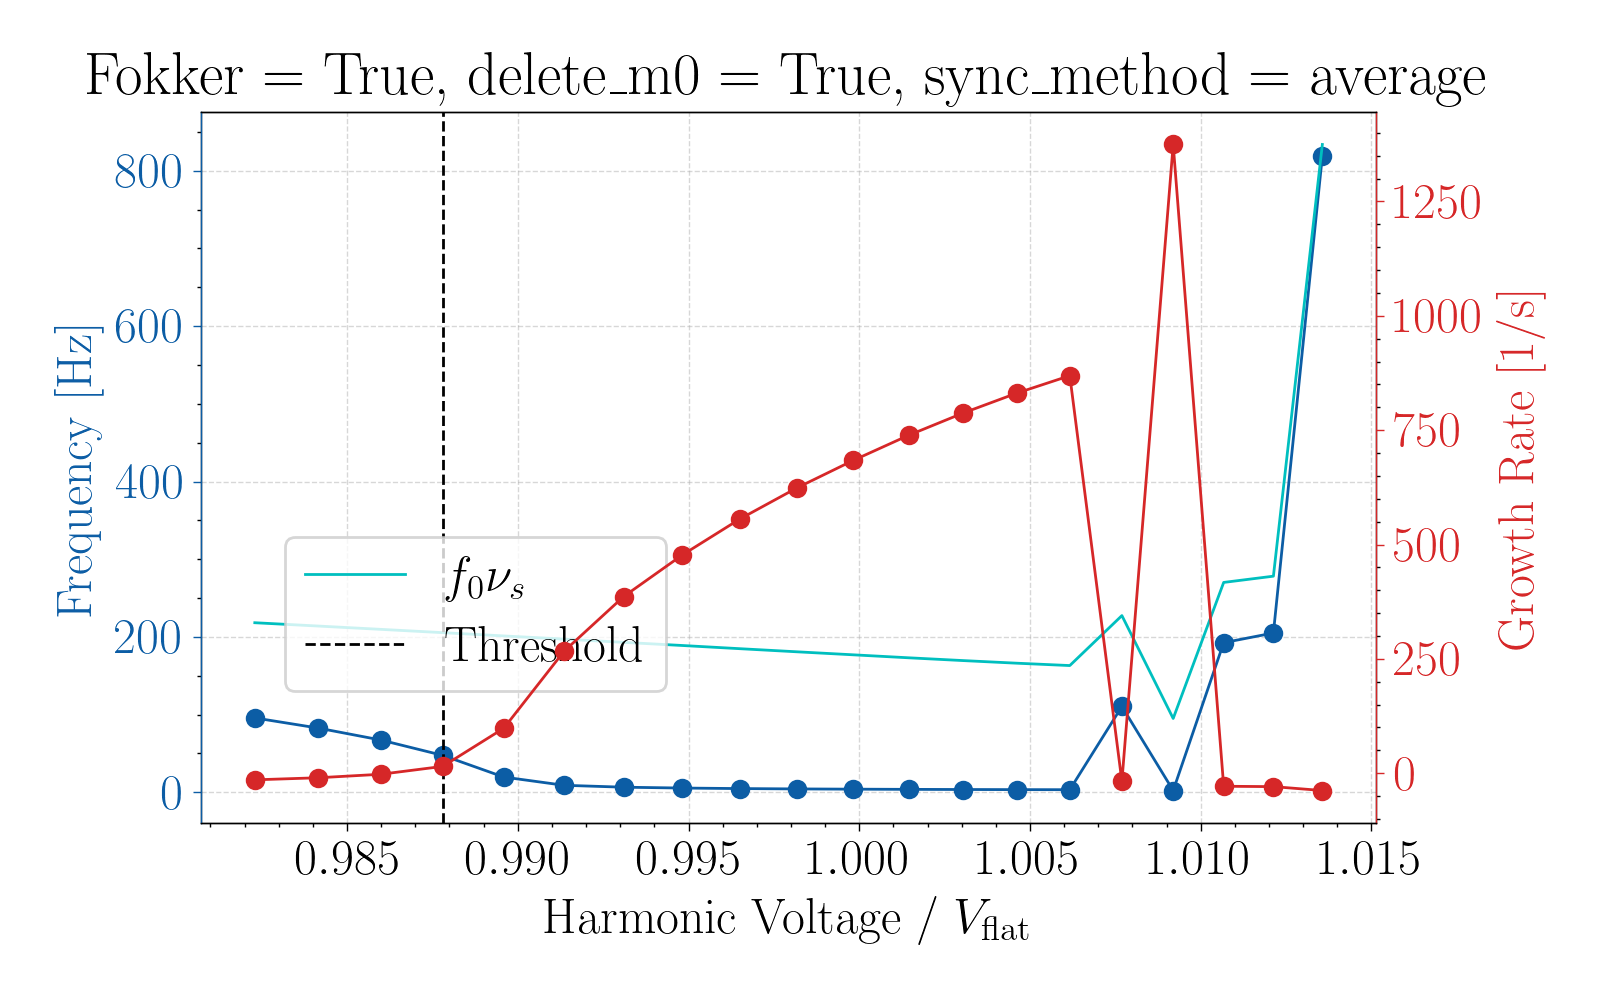

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ay = ax.twinx()

hvol = peak_hvolt / 448e3
ax.plot(hvol, freq, 'o-')
ax.plot(hvol, sync_freq, 'c', label=r'$f_0\nu_s$')
ay.plot(hvol, grate, 'o-', color='tab:red')
ax.axvline(
    hvol[(grate>0).nonzero()[0][0]],
    ls='--',
    color='k',
    label='Threshold',
)

ay.grid(False)
ay.spines['right'].set_color('tab:red')
# plt.setp(ay.yaxis.get_ticklabels(), color='tab:red')
ay.tick_params(axis='y', colors='tab:red')

ay.spines['left'].set_color('C0')
plt.setp(ax.yaxis.get_ticklabels(), color='tab:red')
ax.tick_params(axis='y', colors='C0')

ax.set_title(
    f'Fokker = {fokker}, delete_m0 = {delete_m0}, sync_method = {sync_method:s}')

ax.legend(loc='lower left', frameon=True, bbox_to_anchor=(0.05, 0.15))
ax.set_ylabel('Frequency [Hz]', color='C0')
ax.set_xlabel(r'Harmonic Voltage / $V_\text{flat}$')
# ax.set_xlabel('Harmonic Voltage [kV]')
ay.set_ylabel('Growth Rate [1/s]', color='tab:red')
fig.tight_layout()
fig.show()